In [ ]:
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as  plt
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
from tensorflow import keras

import tensorflow as tf
#fitting for gpu


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

df_clean = pd.read_csv("./drive/My Drive/total_data.csv")
#---------------------------------------------------------------------------------------
given_ingredient = list(df_clean.ingredients)[0:192]
#-----------------------------创建评估用词表--------------------------------------------
reference_recipe = list(df_clean.recipes)
reference_meteor = []
references = []
reference_list = reference_recipe[0:192]
for astr in reference_list:
    alist = astr.split(' ')[1:-1]
    reference_meteor.append(' '.join(alist))
    references.append([alist])
clean_summaries = list(df_clean.ingredients)
clean_texts = list(df_clean.recipes)
sp_dataset = tuple(clean_summaries)
en_dataset = tuple(clean_texts)
#将词语式数据转成ID式
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)#统计词频，生成词表
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')#在句子后面做padding
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset)
output_tensor, output_tokenizer = tokenizer(en_dataset)

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor[192:], output_tensor[192:], test_size=0.01, shuffle=False)

batch_size = 64
epochs = 20
dataset = tf.data.Dataset.from_tensor_slices((input_train, output_train))
train_dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder= True)
train_dataset = train_dataset.shuffle(10000)
eval_dataset = tf.data.Dataset.from_tensor_slices((input_eval, output_eval))
eval_dataset = eval_dataset.repeat(epochs).batch(batch_size, drop_remainder= True)

for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

embedding_units = 256
units = 256
#input_tokenizer.word_index是个字典
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
print(input_vocab_size,output_vocab_size)

#-------------------lstm-----------------------------------
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        #由于用attention，每步输出需要return_sequences = True
        self.gru = keras.layers.LSTM(self.encoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        
    #hidden是初始化的隐含状态
    #这里hidden应该变成[hiddenstate,hiddenc]
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state, state_c = self.gru(x, initial_state = hidden)
        #output = keras.layers.Dropout(0.75)(output)
        return output, state, state_c
    
    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_size, self.encoding_units)),tf.zeros((self.batch_size, self.encoding_units))]
    
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden, sample_c = encoder.call(x, sample_hidden)

print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)
print('sample_memory.shape: ', sample_c.shape)

class BahdanauAttention(keras.Model):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, decoder_hidden, encoder_outputs):
        #decoder_hidden.shape = (batch_size, units)
        #encoder_outputs.shape = (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)#decoder_hidden.shape = (batch_size, 1, units)
        #before V:tf.nn.tanh/shape: (batch_size, length, units)
        #after V:(batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        #shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        #context_vector.shape:(batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        #context_vector.shape:(batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis = 1)#在length上求和
        
        return context_vector, attention_weights

attention_model = BahdanauAttention(units = 10)#units:经过W1之后的units个数，与batch_size, length, units里units不同
attention_results, attention_weights = attention_model.call(sample_hidden,sample_output)

print(attention_results.shape)
print(attention_weights.shape)

#---------------------------------lstm-----------------------------------------
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()#调用父类（keras.Model）的构造函数
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.LSTM(self.decoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
        #x:当前步输入，hidden:前一步输出
    def call(self, x, hidden, encoding_outputs,encoding_state):
        #context_vector.shape: (bathc_size, units)
        context_vector, attention_weights = self.attention.call(hidden, encoding_outputs)
        #befor embedding:x.shape:(batch_size, 1)
        #after embedding:x.shape:(batch_size, 1, embedding_units)
        
        x = self.embedding(x)
        
        combined_x = tf.concat([tf.expand_dims(context_vector, 1),x], axis = -1)
        #output.shape: (batch_size, 1, decoding_units)
        #state.shape: (batch_size, decoding_units)
        output, state, state_c = self.gru(combined_x, initial_state = [hidden,encoding_state])
        #output = keras.layers.Dropout(0.5)(output)
        #output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        #output.shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return context_vector, output, state, attention_weights, state_c
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder.call(tf.random.uniform((batch_size,1)), sample_hidden, sample_output,sample_hidden)

context_vector, decoder_output, decoder_hidden, decoder_aw, state_c = outputs

print(decoder_output.shape)
print(decoder_hidden.shape)
print(decoder_aw.shape)

optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
#from_logits直接经过fc的输出没有经过softmax,如果经过softmax就设成False

def loss_function(real, pred):
    #输出里的padding不应该计算到损失函数中去
    mask = tf.math.logical_not(tf.math.equal(real, 0))#是padding时，mask取0
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

W11 = keras.layers.Dense(1)
W22 = keras.layers.Dense(1)
W33 = keras.layers.Dense(1)


#lstm-----------------------------------------
#@tf.function#加速cell
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden, encoding_c = encoder(inp, encoding_hidden)
        inp = inp.numpy()
        decoding_hidden = encoding_hidden
        decoding_state = encoding_c
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
        for t in range(0, targ.shape[1]-1):
            decoding_input = tf.expand_dims(targ[:, t],1)
            context_vector, predictions, decoding_hidden, decoding_aw, decoding_state = decoder.call(decoding_input, decoding_hidden, encoding_outputs,decoding_state)
            #由decoding.call返回的三维decoding_aw
            attention_weights = np.reshape(decoding_aw, (-1, 35))
            adpre = np.zeros((64,6728))
            
            for index1,sen in enumerate(inp):
                for index2, word_index in enumerate(sen):
                #int means only integer can be used as indices
                    adpre[index1][int(word_index)] = attention_weights[index1][index2]
            #tf.nn.sigmoid之前shape应该是64,1
            prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
            #print(prob.shape)
            adpre = tf.convert_to_tensor(adpre,tf.float32)
            #prob = tf.conver_to_tensor(prob)
            #print(prob)
            #print(adpre)
            new_prediction = (1-prob) * adpre + prob * predictions
            loss += loss_function(targ[:, t+1],new_prediction)
            
    batch_loss = loss / int(targ.shape[0])
        
    variables = encoder.trainable_variables + decoder.trainable_variables + W11.trainable_variables + W22.trainable_variables + W33.trainable_variables
        
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss   

#-------------------------------------------lstm-------------------------
def eval_step(inp, targ, encoding_hidden):
    loss = 0
    
    encoding_outputs, encoding_hidden, encoding_c = encoder(inp, encoding_hidden)
    inp = inp.numpy()
    decoding_hidden = encoding_hidden
    decoding_state = encoding_c
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    for t in range(0, targ.shape[1]-1):
        decoding_input = tf.expand_dims(targ[:, t],1)
        context_vector, predictions, decoding_hidden, decoding_aw, decoding_state = decoder.call(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
        attention_weights = np.reshape(decoding_aw, (-1, 35))
        adpre = np.zeros((64,6728))
        for index1,sen in enumerate(inp):
            for index2, word_index in enumerate(sen):
                #int means only integer can be used as indices
                adpre[index1][int(word_index)] = attention_weights[index1][index2]
            #tf.nn.sigmoid之前shape应该是64,1
        prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
        #print(prob.shape)
        adpre = tf.convert_to_tensor(adpre,tf.float32)
        #prob = tf.conver_to_tensor(prob)
        new_prediction = (1-prob) * adpre + prob * predictions
        loss += loss_function(targ[:, t+1],new_prediction)
            
    batch_loss = loss / int(targ.shape[0])
    return batch_loss 

35 216
(64, 35)
(64, 216)
tf.Tensor(
[[   1   94  150 ...    0    0    0]
 [   1   94  150 ...    0    0    0]
 [   1  365  334 ...    0    0    0]
 ...
 [   1  598 1237 ...    0    0    0]
 [   1   38    3 ...    0    0    0]
 [   1  143   80 ...    0    0    0]], shape=(64, 35), dtype=int32)
tf.Tensor(
[[ 11  52 800 ...   0   0   0]
 [ 11  52 800 ...   0   0   0]
 [ 11  28 754 ...   0   0   0]
 ...
 [ 11  39 590 ...   0   0   0]
 [ 11  28  44 ...   0   0   0]
 [ 11  42  17 ...   0   0   0]], shape=(64, 216), dtype=int32)
3492 6728
sample_output.shape:  (64, 35, 256)
sample_hidden.shape:  (64, 256)
sample_memory.shape:  (64, 256)
(64, 256)
(64, 35, 1)
(64, 6728)
(64, 256)
(64, 35, 1)


In [ ]:
checkpoint_dir = './drive/My Drive/training_checkpoints_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
adict = {'training_loss':[], 'validation_loss':[]}
alist = []
import time
#epochs = 20
epochs = 20
# steps_per_epoch = len(input_tensor[192:18973]) // batch_size
# steps_per_epoch1 = len(input_tensor[18973:]) // batch_size
steps_per_epoch = len(input_train) // batch_size
steps_per_epoch1 = len(input_eval) // batch_size
for epoch in range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_loss1 = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        #inp_np = inp.numpy()
        #print(type(inp_np))
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:4f}'.format(epoch+1, batch, batch_loss.numpy()))
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    for (batch1, (inp, targ)) in enumerate(eval_dataset.take(steps_per_epoch1)):
        eval_loss = eval_step(inp, targ, encoding_hidden)
        total_loss1 += eval_loss
               
            
      
    print('Epoch {} Loss {:4f}'.format(epoch+1, total_loss / steps_per_epoch))
    print('Epoch {} Eval_Loss {:4f}'.format(epoch+1, total_loss1 / steps_per_epoch1))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))
    adict['training_loss'].append(round(float(total_loss / steps_per_epoch),3))
    adict['validation_loss'].append(round(float(total_loss1 / steps_per_epoch1),3))
print(adict)

Epoch 1 Batch 0 Loss 13.376207
Epoch 1 Batch 100 Loss 8.368586
Epoch 1 Batch 200 Loss 6.225659
Epoch 1 Loss 7.905094
Epoch 1 Eval_Loss 6.642586
Time take for 1 epoch 1246.3067066669464 sec

Epoch 2 Batch 0 Loss 6.315050
Epoch 2 Batch 100 Loss 5.522377
Epoch 2 Batch 200 Loss 4.432110
Epoch 2 Loss 5.326563
Epoch 2 Eval_Loss 5.168204
Time take for 1 epoch 1274.3145530223846 sec

Epoch 3 Batch 0 Loss 4.728727
Epoch 3 Batch 100 Loss 4.707995
Epoch 3 Batch 200 Loss 4.448650
Epoch 3 Loss 4.372831
Epoch 3 Eval_Loss 4.604950
Time take for 1 epoch 1276.9049258232117 sec

Epoch 4 Batch 0 Loss 4.166028
Epoch 4 Batch 100 Loss 3.674957
Epoch 4 Batch 200 Loss 4.241487
Epoch 4 Loss 3.949413
Epoch 4 Eval_Loss 4.313187
Time take for 1 epoch 1216.4536318778992 sec

Epoch 5 Batch 0 Loss 3.603842
Epoch 5 Batch 100 Loss 3.665158
Epoch 5 Batch 200 Loss 3.709671
Epoch 5 Loss 3.705515
Epoch 5 Eval_Loss 4.142481
Time take for 1 epoch 1207.6966531276703 sec

Epoch 6 Batch 0 Loss 3.352840
Epoch 6 Batch 100 Loss 3

In [ ]:
#从新加载训练好的模型
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as  plt
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
from tensorflow import keras
import tensorflow as tf
optimizer = keras.optimizers.Adam()
checkpoint_dir = './drive/My Drive/training_checkpoints_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> tomatoes eggs sugar salt <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9 inch pie plate . in a medium bowl , mix together eggs , sugar , and salt . place in a single layer on a baking sheet . bake in the preheated oven until golden brown , about 10 minutes . <end> 


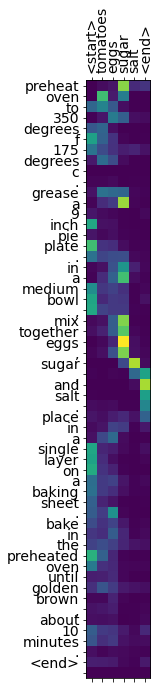

'preheat oven to 350 degrees f 175 degrees c . grease a 9 inch pie plate . in a medium bowl , mix together eggs , sugar , and salt . place in a single layer on a baking sheet . bake in the preheated oven until golden brown , about 10 minutes . <end> '

In [ ]:
#Caution: 在不画图的时候一定要将下面两行代码注释掉
import matplotlib.ticker as ticker
#-------------------lstm----------------
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    #这里的encoding_hidden在lstm情况下需要改一下维度
    encoding_hidden = [tf.zeros((1,units)),tf.zeros((1,units))]
    
    encoding_outputs, encoding_hidden, encoding_c = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    decoding_state = encoding_c
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        context_vector, predictions, decoding_hidden, decoding_aw, decoding_state = decoder(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
        
         #-------------------------------------------------------------------------
        attention_weights = np.reshape(decoding_aw, (-1, 35))
        #经历过上一步后attention_weights.shape = 1,35
        adpre = np.zeros((1,6728))
        for index1,sen in enumerate(inputs):
            for index2, word_index in enumerate(sen):
                #int means only integer can be used as indices
                adpre[index1][int(word_index)] = attention_weights[index1][index2]
            #tf.nn.sigmoid之前shape应该是64,1
        prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
        #print(prob.shape)
        adpre = tf.convert_to_tensor(adpre,tf.float32)
        #prob = tf.conver_to_tensor(prob)
        new_prediction = (1-prob) * adpre + prob * predictions
        #-------------------------------------------------------------------------------
        
        attention_weights = tf.reshape(decoding_aw, (-1,))#length=16的向量
        attention_matrix[t] = attention_weights.numpy()#attention_weights是一个tensor，用numpy（）取出它的值
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        
        predicted_id = tf.argmax(new_prediction[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(11,11))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results


#----------------------BLEU and Meteor------------------------------
translate('<start> tomatoes eggs sugar salt <end>')

In [ ]:
#Caution: 在不画图的时候一定要将下面两行代码注释掉
import matplotlib.ticker as ticker
#-------------------lstm----------------
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    #这里的encoding_hidden在lstm情况下需要改一下维度
    encoding_hidden = [tf.zeros((1,units)),tf.zeros((1,units))]
    
    encoding_outputs, encoding_hidden, encoding_c = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    decoding_state = encoding_c
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        context_vector, predictions, decoding_hidden, decoding_aw, decoding_state = decoder(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
        
         #-------------------------------------------------------------------------
        attention_weights = np.reshape(decoding_aw, (-1, 35))
        #经历过上一步后attention_weights.shape = 1,35
        adpre = np.zeros((1,6728))
        for index1,sen in enumerate(inputs):
            for index2, word_index in enumerate(sen):
                #int means only integer can be used as indices
                adpre[index1][int(word_index)] = attention_weights[index1][index2]
            #tf.nn.sigmoid之前shape应该是64,1
        prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
        #print(prob.shape)
        adpre = tf.convert_to_tensor(adpre,tf.float32)
        #prob = tf.conver_to_tensor(prob)
        new_prediction = (1-prob) * adpre + prob * predictions
        #-------------------------------------------------------------------------------
        
        attention_weights = tf.reshape(decoding_aw, (-1,))#length=16的向量
        attention_matrix[t] = attention_weights.numpy()#attention_weights是一个tensor，用numpy（）取出它的值
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        
        predicted_id = tf.argmax(new_prediction[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    #attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    #plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results


#----------------------BLEU and Meteor------------------------------
candidates = []
candidates_meteor = []
for sample1 in clean_summaries[0:192]:
    #res = translate(sample1+', ')
    res = translate(sample1)
    candidates_meteor.append(res)
    candidates.append(res.split(' '))



Input: <start> skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . bring a large pot of lightly salted water to a boil . add chicken and cook until tender , about 15 minutes . drain . in a large bowl , cream butter and chicken broth . add chicken and onion and mix well . pour mixture into a 9x13 inch baking dish . bake in preheated oven for 30 minutes . remove from oven and let stand for 5 minutes . remove from oven and let cool . <end> 
Input: <start> condensed cream mushroom soup package dry onion soup mix water pot roast <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . in a medium bowl , mix together the cream of mushroom soup , onion soup mix and water . place the roast in a 9x13 inch baking dish . bake in the preheated oven until the sauce is bubbly and the sauce is bubbly and the sauce is bubbly , about 45 

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(references, candidates,weights=(1,0,0,0))
score1 = corpus_bleu(references, candidates,weights=(0.33,0.33,0.33,0))
score2 = corpus_bleu(references, candidates,weights=(0.25,0.25,0.25,0.25))
print(score,score1,score2)

0.48533595978458605 0.25547507010259235 0.19386949182983637


In [ ]:
def calculate_given_item(given_ingredient, generated_recipe):
    '''
    given_ingredient = ['egg tomatoes','chicken']
    splitted_ingredient = [['egg','tomatoes'],['chicken']]
    generated_recipe = [['use','egg'],['use','chicken'],...]
    '''

    total_score = 0
    extra_score = 0
    splitted_ingredient = []
    for bstr in given_ingredient:
        splitted_ingredient.append(bstr.split(' '))

    for index, each_sample in enumerate(splitted_ingredient):
        # count1 covered items
        # count2 extra items
        count1 = 0
        count2 = 0
        for each_word in each_sample:
            # generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in generated_recipe[index]:
                count1 += 1
            else:
                count2 += 1
        extra_score += count2 / len(each_sample)
        total_score += count1 / len(each_sample)
    # -------------------------------------------------------------------------
    for index, each_recipe in enumerate(generated_recipe):
        # count1 covered items
        # count2 extra items
        extra_item = 0
        for each_word in each_recipe:
            # generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in input_tokenizer.word_index and each_word not in splitted_ingredient[index]:
                extra_item += 1

    # --------------------------------------------------------------------------

    total_score = total_score / len(given_ingredient)

    return total_score, extra_item

cover_item, extra_item = calculate_given_item(given_ingredient, candidates)
print(cover_item,extra_item)

0.4735924005843571 21


In [ ]:
print(reference_meteor)

['place the chicken , butter , soup , and onion in a slow cooker , and fill with enough water to cover . cover , and cook for 5 to 6 hours on high . about 30 minutes before serving , place the torn biscuit dough in the slow cooker . cook until the dough is no longer raw in the center .', 'in a slow cooker , mix cream of mushroom soup , dry onion soup mix and water . place pot roast in slow cooker and coat with soup mixture . cook on high setting for 3 to 4 hours , or on low setting for 8 to 9 hours .', 'preheat oven to 350 degrees f 175 degrees c . lightly grease a 9x5 inch loaf pan . in a large bowl , combine flour , baking soda and salt . in a separate bowl , cream together butter and brown sugar . stir in eggs and mashed bananas until well blended . stir banana mixture into flour mixture stir just to moisten . pour batter into prepared loaf pan . bake in preheated oven for 60 to 65 minutes , until a toothpick inserted into center of the loaf comes out clean . let bread cool in pan f

In [ ]:
print(candidates_meteor)

['preheat oven to 350 degrees f 175 degrees c . bring a large pot of lightly salted water to a boil . add chicken and cook until tender , about 15 minutes . drain . in a large bowl , cream butter and chicken broth . add chicken and onion and mix well . pour mixture into a 9x13 inch baking dish . bake in preheated oven for 30 minutes . remove from oven and let stand for 5 minutes . remove from oven and let cool . <end> ', 'preheat oven to 350 degrees f 175 degrees c . in a medium bowl , mix together the cream of mushroom soup , onion soup mix and water . place the roast in a 9x13 inch baking dish . bake in the preheated oven until the sauce is bubbly and the sauce is bubbly and the sauce is bubbly , about 45 minutes . <end> ', 'preheat oven to 350 degrees f 175 degrees c . grease and flour a 10 inch tube pan . sift flour , baking soda , and salt together in a bowl . beat butter and brown sugar together in a bowl until smooth . beat in eggs and vanilla extract . mix in flour mixture unti